In [362]:
# Loading libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [363]:
# Import the dataset
kickstarter = pd.read_excel('Kickstarter.xlsx')

In [364]:
# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df = kickstarter[kickstarter['state'].isin(['successful','failed'])]

# Convert the target variable to binary
df['state'] = df['state'].replace(['successful','failed'],[1,0])

df.head()

C:\Users\shans\AppData\Local\Temp\ipykernel_21916\2678655226.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['state'].replace(['successful','failed'],[1,0])


,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days
0,1601563193,Our future,100000000.0,1.00,0,False,AU,AUD,2014-10-07 12:05:39,2014-10-07 12:05:39,...,1,2014,21,8,8,2014,12,6,60,60
1,880009511,Elite: Dangerous,1250000.0,1578316.08,1,False,GB,GBP,2013-01-04 18:00:57,2013-01-04 18:00:57,...,31,2012,11,11,5,2012,18,5,60,60
4,557230947,"Bring Reading Rainbow Back for Every Child, Ev...",1000000.0,5408916.95,1,False,US,USD,2014-07-02 14:00:00,2014-07-02 14:00:11,...,22,2014,22,5,28,2014,8,35,35,35
5,1966069095,ARKYD: A Space Telescope for Everyone,1000000.0,1505366.60,1,False,US,USD,2013-06-30 21:00:00,2013-06-30 21:00:34,...,10,2012,17,5,29,2013,10,322,32,32
6,2083255961,A Billion Pixels...,100000000.0,56.00,0,False,US,USD,2014-08-04 16:39:34,2014-08-04 16:39:34,...,1,2014,16,6,5,2014,16,34,60,60


# 1. Data Preprocessing

In [ ]:
# Understand the data type of each column
df.dtypes

Clustering algorithms do not work well with categorical variable (either binary or multi-class), especially K-Means.

We should consider removing all categorical variables, including: 
- datetime and those sub-columns
- category
- currency and static_usd_rate

In [ ]:
df.columns

In [365]:
# Select only numeric values
df = df[['goal', 'pledged', 'backers_count', 'state',
       'usd_pledged', 'name_len', 'name_len_clean',
       'blurb_len', 'blurb_len_clean', 
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days']]

Check if there is any collinearity between variables

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap_clustering.png', dpi=300, bbox_inches='tight')

According to the correlation heatmap, following varaibles have high correlation (>0.75):
- usd_pledged and pledged,
- pledged and backers_count,
- name_len and name_len_clean, 
- blurb_len and blurb_len_clean,
- launch_to_deadline_days and launch_to_state_change_days

For each pair, we only need to keep one of them.

In [366]:
df = df.drop(columns = ['usd_pledged','name_len_clean','launch_to_state_change_days', 'backers_count', 'blurb_len_clean'])
df.columns

Index(['goal', 'pledged', 'state', 'name_len', 'blurb_len',
       'create_to_launch_days', 'launch_to_deadline_days'],
      dtype='object')

# 2. Define Clusters Measurement

In [367]:
from sklearn.metrics import silhouette_samples

newdf = df
def cal_silhouette(labels):
    silhouette = silhouette_samples(X_std, labels)
         # silhouette score for each indiviual data points, > 0.5 is strong
    newdf['labels'] = labels
    newdf['silhouette'] = silhouette

    K = len(np.unique(labels))
    print('Average Silhouette Score for each cluster:')
    for i in range(K):
        print(i,'=',np.average(newdf[newdf['labels'] == i].silhouette))


# 3. Clustering Analysis

In [368]:
X = df #[['goal','pledged']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## 3.1 K-Means Clustering

### 3.1.1 Find the optimal K

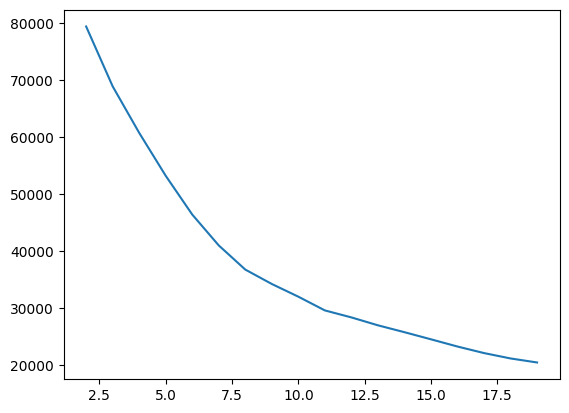

In [369]:
# Calculate inertia for each number of clusters in kmeans
from sklearn.cluster import KMeans

withinss = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(X_std)
    withinss.append(model.inertia_)

from matplotlib import pyplot
pyplot.plot([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],withinss)

### 3.1.2 Run the model with optimal K

In [370]:
K = 8

In [371]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K)
model_km = kmeans.fit(X_std)
labels_km = model_km.predict(X_std)

for i in range(K):
    print(i, (labels_km == i).sum())

0 3780
1 3153
2 5
3 441
4 1691
5 51
6 2785
7 1529


In [ ]:
cal_silhouette(labels_km)

In [ ]:
X.columns

In [373]:
cluster_df = pd.DataFrame(scaler.inverse_transform(model_km.cluster_centers_), columns = X.columns)
cluster_df.loc['Mean'] = X.mean().to_numpy() #np.mean(X_std, axis=0)

cluster_df

,goal,pledged,state,name_len,blurb_len,create_to_launch_days,launch_to_deadline_days
0,1.929692e+04,4.464361e+04,1.000000e+00,6.623246,19.924279,35.567117,30.364575
1,6.783847e+04,3.993840e+03,8.881784e-16,8.087853,20.481763,34.773549,30.701554
2,7.100000e+07,2.540000e+01,-5.551115e-17,3.800000,17.400000,8.600000,44.800000
3,5.666484e+04,2.410209e+04,3.197279e-01,6.455782,18.766440,483.503401,35.548753
4,1.876903e+05,7.990193e+03,1.566194e-01,5.457447,19.911348,29.750000,58.442080
5,2.174689e+05,1.439677e+06,1.000000e+00,6.960784,19.254902,65.431373,40.666667
6,6.807163e+04,1.427465e+03,-4.996004e-16,3.081867,20.628366,24.597127,30.035189
7,5.521680e+04,7.428131e+03,2.227302e-01,4.198563,10.298498,31.751796,33.163292
Mean,9.449554e+04,2.189293e+04,3.405285e-01,5.804466,19.061035,46.746185,34.445032


## 3.2. Agglomerative Approach

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def quick_agg(linkage): 
    model = AgglomerativeClustering(n_clusters=K,affinity='euclidean',linkage=linkage)
    model.fit_predict(X_std)
    labels = model.labels_

    print('\nLinkage = ', linkage)
    for i in range(K):
        print(i, (model.labels_ == i).sum())
    
    return labels, model.cluster_centers_

In [ ]:
labels_complete = quick_agg('complete')
labels_single = quick_agg('single')
labels_average = quick_agg('average')

In [ ]:
cal_silhouette(labels_complete)
cal_silhouette(labels_single)
cal_silhouette(labels_average)

## 3.3. DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

model_dbscan = DBSCAN(eps=2.5, min_samples=10)
labels_dbscan = model_dbscan.fit_predict(df)

np.unique(labels_dbscan)

In [ ]:
K = len(np.unique(labels_dbscan))
for i in range(K):
    print(i, (model_average.labels_ == i).sum())

In [ ]:
cal_silhouette(labels_dbscan)